In [6]:
# autoreload -- Use for development only
%load_ext autoreload
%autoreload 2

In [18]:
%matplotlib inline

# Carefully interpreting your model

In [1]:
# Double check you have a GPU available
import torch
torch.cuda.is_available()

True

In [5]:
# Define any useful paths
import os
import glob
cwd = "/cellar/users/aklie/projects/ML4GLand/use_cases/jores21"

# Load data

In [3]:
# Load in the preprocessed training data
import seqdata as sd
leaf_test = sd.read_h5sd("/cellar/users/aklie/data/eugene/jores21/leaf_processed_test.h5sd")
leaf_test

SeqData object with = 7154 seqs
seqs = (7154,)
names = (7154,)
rev_seqs = None
ohe_seqs = (7154, 4, 170)
ohe_rev_seqs = None
seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'type'
pos_annot: None
seqsm: None
uns: None

In [4]:
# One-hot encode the sequences
from eugene import preprocess as pp
pp.ohe_seqs_sdata(leaf_test)

# Load trained model

In [2]:
import seqexplainer as se

In [6]:
model_file = glob.glob(os.path.join(cwd, "models", "grace", "leaf", "checkpoints", "*.ckpt"))[0]
model_file

'/cellar/users/aklie/projects/ML4GLand/use_cases/jores21/models/grace/leaf/checkpoints/epoch=10-step=5027.ckpt'

In [7]:
# Load the model
model = se.load_eugene_model(model_file)

In [16]:
# Grab precitions from the model
leaf_test["enrichment_predictions"] = model.predict(leaf_test.ohe_seqs, batch_size=128).cpu().numpy()

Predicting on batches:   0%|          | 0/55 [00:00<?, ?it/s]

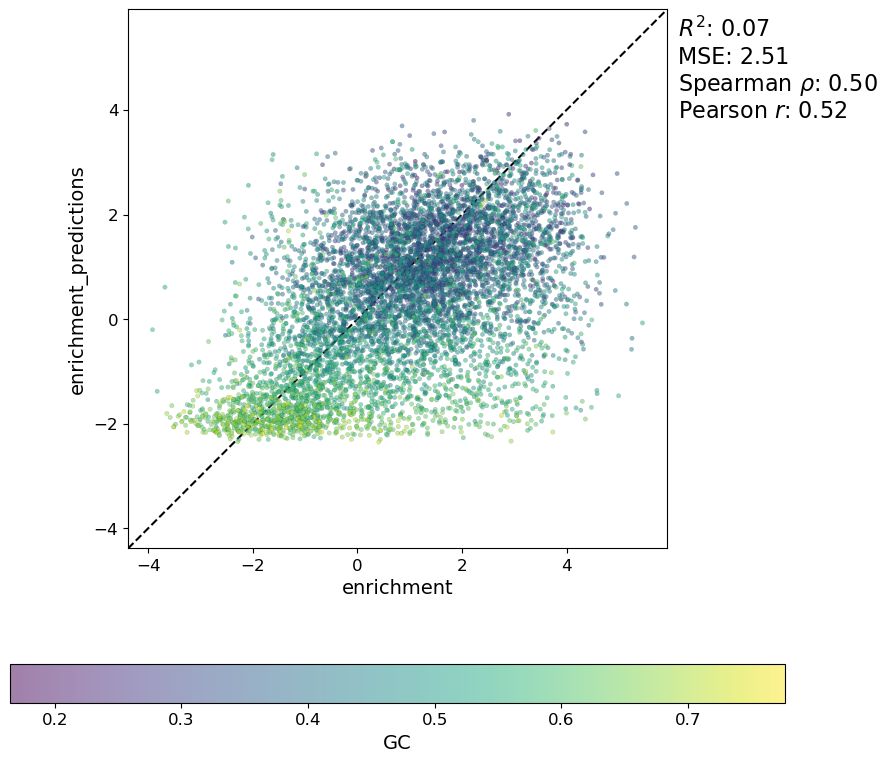

In [19]:
# Plot the predictions and metrics
from eugene import plot as pl
ax = pl.performance_scatter(
    leaf_test,
    target_keys="enrichment", 
    prediction_keys="enrichment_predictions",
    alpha=0.5,
    figsize=(10, 10),
)

# Feature attribution

In [59]:
from seqexplainer._attributions import attribute
from seqexplainer._attributions import plot_attribution_logo, plot_attribution_logos
from seqexplainer._attributions import attribution_pca, attribution_umap

In [30]:
attrs = se.attribute(
    model,
    inputs=leaf_test.ohe_seqs[:256],
    method="GradientShap",
    reference_type="zero",
    batch_size=128,
    device="cuda"
)

Computing attributions on batches of size 128:   0%|          | 0/2 [00:00<?, ?it/s]

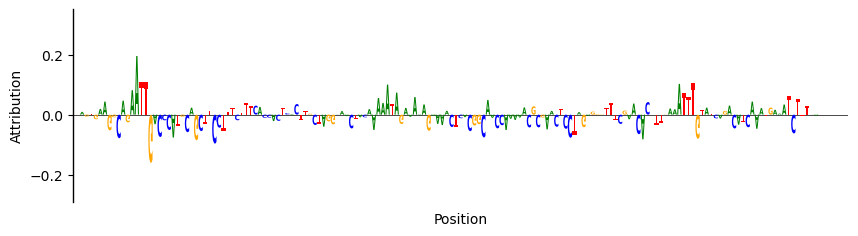

In [53]:
plot_attribution_logo(attrs[0])

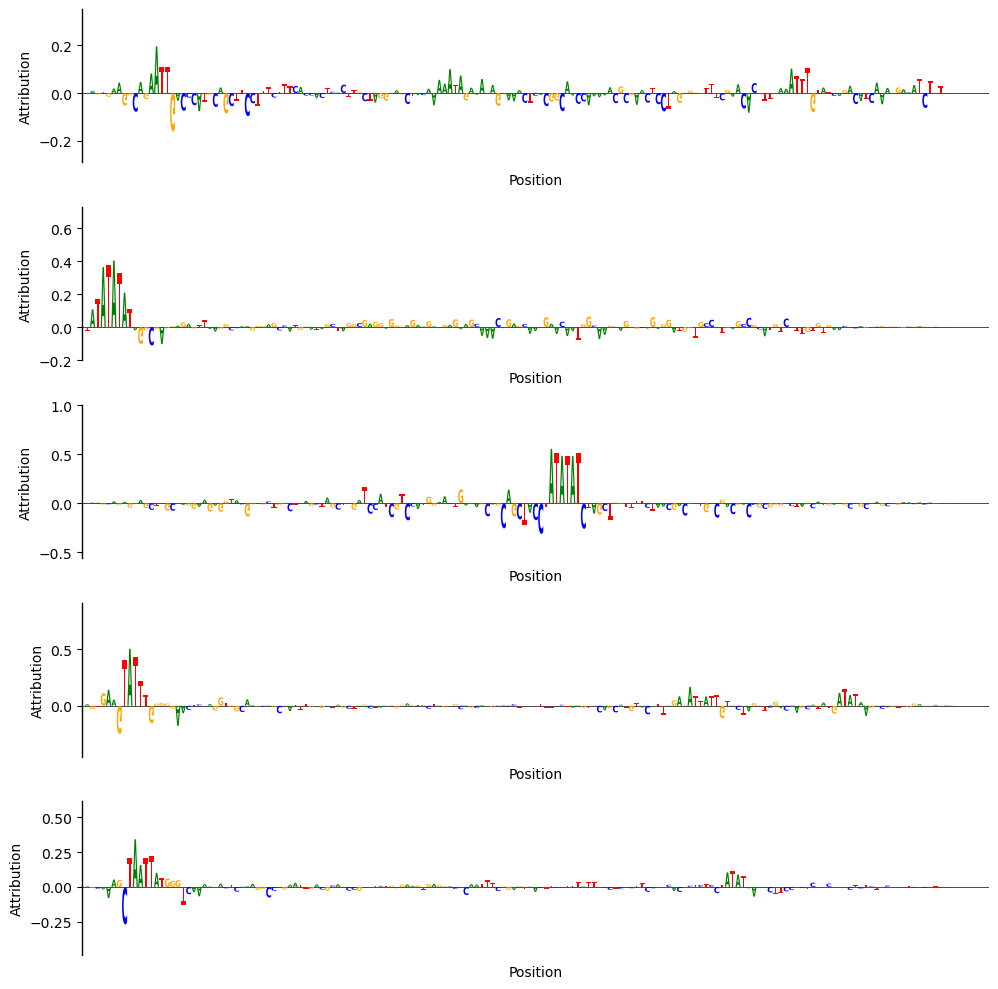

In [57]:
plot_attribution_logos(attrs[:5])

In [63]:
pca_obj, pca_df = attribution_pca(attrs, leaf_test.ohe_seqs[:256])

Make sure your matrix is sample by feature


In [1]:
import torchinfo

In [8]:
torchinfo.summary(model, input_size=(1, 4, 1000))

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Hybrid                                   [1, 1]                    --
├─Conv1DTower: 1-1                       [1, 256, 114]             --
│    └─Sequential: 2-1                   [1, 256, 114]             --
│    │    └─Conv1d: 3-1                  [1, 256, 988]             13,568
│    │    └─ReLU: 3-2                    [1, 256, 988]             --
│    │    └─MaxPool1d: 3-3               [1, 256, 494]             --
│    │    └─Dropout: 3-4                 [1, 256, 494]             --
│    │    └─BatchNorm1d: 3-5             [1, 256, 494]             512
│    │    └─Conv1d: 3-6                  [1, 256, 482]             852,224
│    │    └─ReLU: 3-7                    [1, 256, 482]             --
│    │    └─MaxPool1d: 3-8               [1, 256, 241]             --
│    │    └─Dropout: 3-9                 [1, 256, 241]             --
│    │    └─BatchNorm1d: 3-10            [1, 256, 241]             512
│   

In [66]:
import seaborn as sns

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

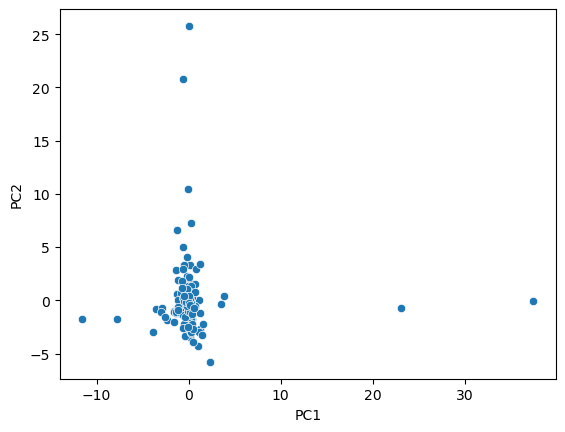

In [67]:
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
)

# Filter interpretation

In [110]:
layer_name = "conv1d_tower.layers.1"

In [524]:
from seqexplainer._utils import get_layer_outputs
from seqexplainer._filters import get_activators_n_seqlets, get_activators_max_seqlets
from seqexplainer._filters import get_pfms, pfms_to_df_dict
from seqexplainer._filters import pfms_to_ppms, ppms_to_pwms, ppms_to_igms, per_position_ic
from seqexplainer._filters import plot_filter_logo, plot_filter_logos

In [525]:
sequences = leaf_test.ohe_seqs
layer_outs = get_layer_outputs(model, sequences, layer_name, device="cuda")
activators = get_activators_n_seqlets(
    layer_outs,
    sequences,
    kernel_size=13,
    num_seqlets=100
)
pfms = get_pfms(activators)
pfm_dfs = pfms_to_df_dict(pfms)
ppms = pfms_to_ppms(pfms, pseudocount=1)
pwms = ppms_to_pwms(ppms)
infos = ppms_to_igms(ppms)
ppics = per_position_ic(ppms)
tot_ics = ppics.sum(axis=1)

Computing layer outputs for layer conv1d_tower.layers.1 on batches of size 128:   0%|          | 0/56 [00:00<?…

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

In [526]:
# Sort by total information content
sort_idx = np.argsort(tot_ics)[::-1]
sort_idx[:5]

array([50, 46, 72, 71,  0])

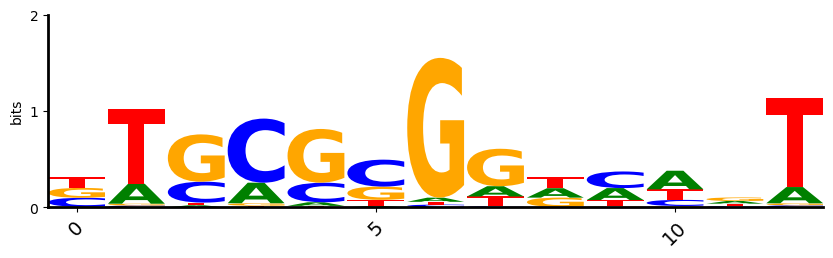

In [534]:
plot_filter_logo(mtx=pfms[sort_idx[-1]], mtx_type="counts")

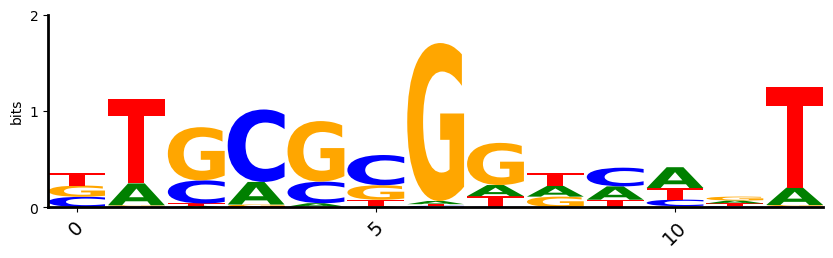

In [535]:
plot_filter_logo(mtx=ppms[sort_idx[-1]], mtx_type="probability")

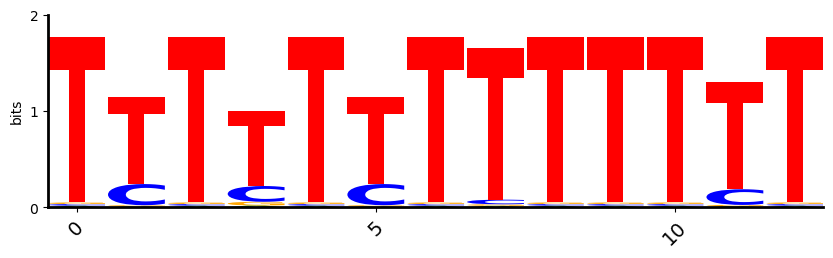

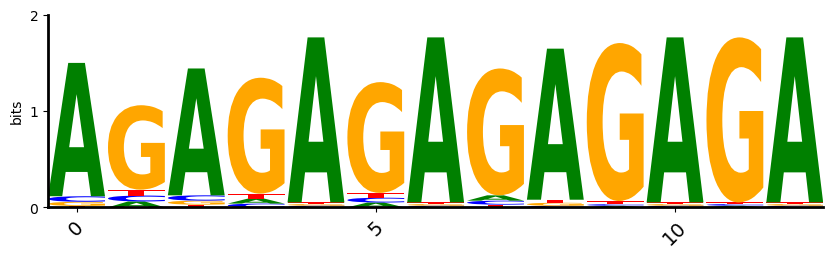

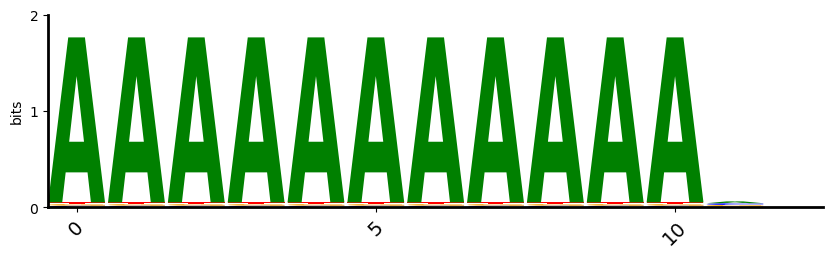

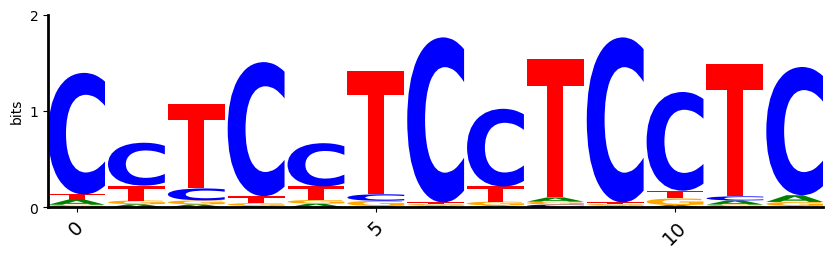

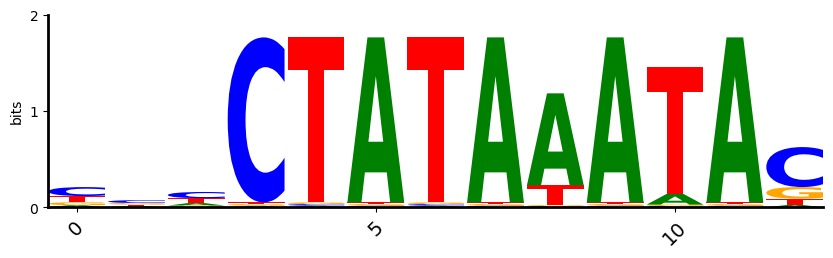

In [533]:
plot_filter_logos(mtxs=ppms[sort_idx[:5]], mtx_type="probability")

---

# DONE!

# Scratch

In [ ]:
# Test against Peter Koo's code
import numpy as np
TINY = np.finfo(np.float32).tiny
def compute_per_position_ic(ppm, background, pseudocount):
    alphabet_len = len(background)
    ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
          *ppm - (np.log(background)*background/np.log(2))[None,:])
    return np.sum(ic,axis=1)
compute_per_position_ic(ppms[0], np.array([0.25, 0.25, 0.25, 0.25]), TINY)

In [ ]:
# Test against logomaker
from logomaker.src.matrix import _probability_mat_to_information_mat
_probability_mat_to_information_mat(pd.DataFrame(ppms[0]))

In [ ]:

def plot_attribution_logos(explains, sort, width=13, height_per_explain=1):
    """
    Plot the saliency maps for each sequence
    """
    num_plot = len(explains)
    fig = plt.figure(figsize=(width, num_plot*height_per_explain))
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
        saliency_df.index.name = "pos"
        tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(num_plot,1))
        plt.ylabel(sort[i])